In [1]:
import numpy as np
from scipy.linalg import pinv, svd, eigvals, svdvals, logm, expm
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

In [2]:
def lorenz(t, u, p):
    # --> Unpack parameters.
    σ, ρ, β = p
    
    # --> Unpack variables.
    x, y, z = u
    
    # --> Lorenz system.
    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x*y - β*z
    
    return dx, dy, dz

In [106]:
# --> Parameters of the simulation.
tspan = (0.0, 400.0)
t = np.linspace(*tspan, 400001)
p = σ, ρ, β = [10.0, 28.0, 8.0/3.0]

# --> Initial condition.
u0 = np.random.randn(3)

# --> Simulation.
output = solve_ivp(
    lambda t, u : lorenz(t, u, p),
    tspan,
    u0,
    t_eval=t,
)

# --> Re-run simulation to have only data on the attractor.
u0 = output["y"][:, -1]
output = solve_ivp(
    lambda t, u : lorenz(t, u, p),
    tspan,
    u0,
    t_eval=t,
)

# --> Extract observables.
y = output["y"]
Δt = t[1] - t[0]

In [107]:
Δt

0.001

[[], Text(0, 0.5, '$x(t)$'), (0.0, 50.0)]

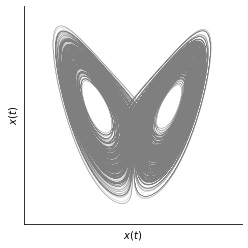

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(y[0], y[-1], alpha=0.5, lw=0.25, c="k")
ax.set_aspect("equal")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set(xticks=[], xlabel=r"$x(t)$", xlim=(-25, 25))
ax.set(yticks=[], ylabel=r"$x(t)$", ylim=(0, 50))

In [109]:
# --> Define Hankel matrix function.
def Hankel(y, m):
    
    # --> Size of the Hankel matrix.
    n = len(y)-m
    
    # --> Create the container.
    H = np.empty((m, n))
    
    # --> Fill-in the rows.
    for i in range(m):
        H[i, :] = y[i:-m+i]
        
    return H

In [110]:
def cca_era(y, m, Δt=1, rank=2, q=1, p=1):
    # --> Form the first Hankel matrix.
    X = Hankel(y[:-1], m)

    # --> Forms the one-step-ahead Hankel matrix.
    Y = Hankel(y[1:], m)
    
    print(X.shape, Y.shape)

    Uy, Σy, Vy = svd(Y, full_matrices=False)
    Vy = Vy.T

    Ux, Σx, Vx = svd(X, full_matrices=False)
    Vx = Vx.T

    Σ = svdvals(np.diag(Σy) @ Vy.T @ Vx @ np.diag(Σx))
    
    Ux, Vx = Ux[:, :rank], Vx[:, :rank]
    Uy, Vy = Uy[:, :rank], Vy[:, :rank]

    Â, R, B̂t = svd(Vy.T @ Vx)
    B̂ = B̂t.T
    
    P = Uy @ pinv(np.diag(Σy[:rank])) @ Â
    Q = Ux @ pinv(np.diag(Σx[:rank])) @ B̂

    Obs = pinv(Q.T)

    C = Obs[:q].reshape(q, -1)
    A = Q.T @ pinv(P.T)
    
    return A, C, Σ, Obs, X, Y

In [111]:
obs = y[0]
A, C, Σ, Obs, X, Y = cca_era(obs - np.mean(obs), 100, rank=5)

(100, 399900) (100, 399900)


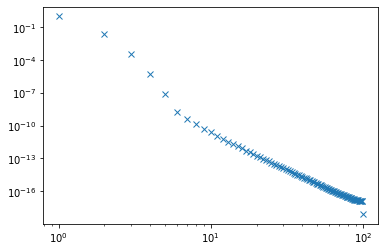

In [112]:
plt.loglog(np.arange(1, len(Σ)+1), Σ/np.sum(Σ), 'x')

[0.00109582 0.9879578 ]
[ 1.00610975 -0.01608383]
[ 1.259165   -0.04785781 -0.28776233]
[ 1.71485831 -0.05060328 -0.74082433  0.00720884]
[-2.55717249  0.09952087  1.72879008 -0.03329476 -0.12484189]


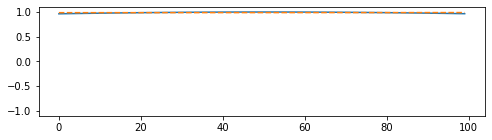

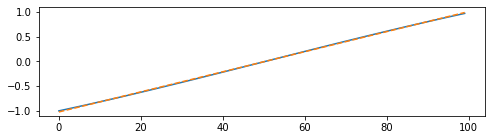

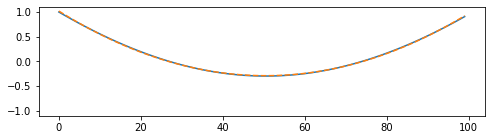

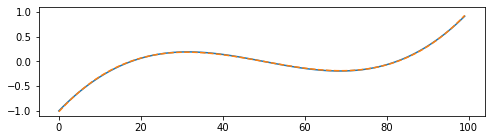

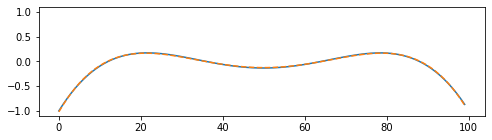

In [113]:
for i in range(Obs.shape[1]):
    fig = plt.figure(figsize=(8, 2))
    plt.plot(Obs[:, i] / abs(Obs[:, i]).max())
    plt.ylim(-1.1, 1.1)
    
    z = np.arange(0, Obs.shape[0])
    ξ = (z - z.max()/2) / (z.max()/2)
    if i == 0:
        p = np.polyfit(ξ, Obs[:, i]/abs(Obs[:, i]).max(), 1)
        plt.plot(z, np.polyval(p, ξ), '--')
        print(p)
    if i == 1:
        p = np.polyfit(ξ, Obs[:, i]/abs(Obs[:, i]).max(), 1)
        plt.plot(z, np.polyval(p, ξ), '--')        
        print(p)
    if i == 2:
        p = np.polyfit(ξ, Obs[:, i]/abs(Obs[:, i]).max(), 2)
        plt.plot(z, np.polyval(p, ξ), '--')
        print(p)
    if i == 3:
        p = np.polyfit(ξ, Obs[:, i]/abs(Obs[:, i]).max(), 3)
        plt.plot(z, np.polyval(p, ξ), '--')
        print(p)        
    if i == 4:
        p = np.polyfit(ξ, Obs[:, i]/abs(Obs[:, i]).max(), 4)
        plt.plot(z, np.polyval(p, ξ), '--')
        print(p)        

In [114]:
x = pinv(Obs) @ Y

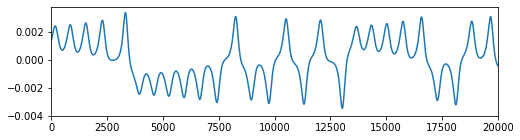

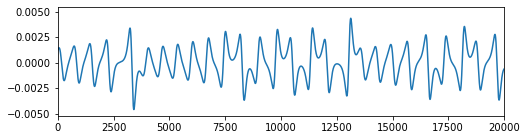

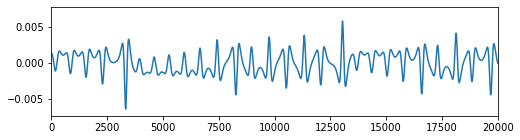

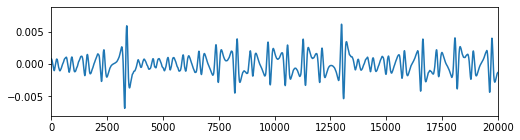

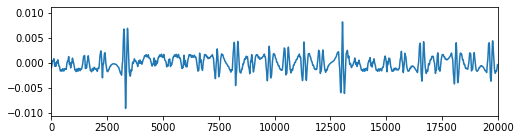

In [138]:
for i in range(len(x)):
    fig = plt.figure(figsize=(8, 2))
    plt.plot(x[i])
    plt.xlim(0, 20000)

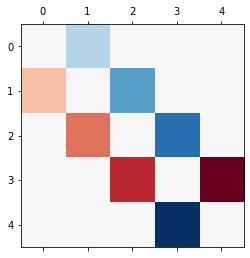

In [116]:
amp = np.abs(A-np.diag(np.diag(A))).max()
plt.matshow(A-np.diag(np.diag(A)), cmap="RdBu", vmin=-amp, vmax=amp)

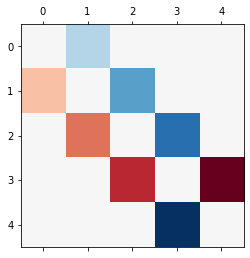

In [117]:
amp = abs(logm(A)).max()
plt.matshow(logm(A), cmap="RdBu", vmin=-amp, vmax=amp)

In [118]:
abs(eigvals(A))

array([0.99999824, 0.99999961, 0.99999961, 1.        , 1.        ])

In [119]:
eigvals(logm(A)/Δt)

array([-1.76070443e-03 +0.j        , -3.89203686e-04 +9.24429499j,
       -3.89203686e-04 -9.24429499j,  1.68328587e-06+23.69319704j,
        1.68328587e-06-23.69319704j])

In [120]:
B = logm(A)/Δt
B = (B - B.T)/2

In [121]:
eigvals(B)

array([-3.33639255e-018 +0.j        ,  2.72509430e-107 +9.2442951j ,
        2.72509430e-107 -9.2442951j ,  4.77918169e-018+23.69319705j,
        4.77918169e-018-23.69319705j])

In [122]:
23.70885242j / 9.24659285j

(2.5640636291236722+0j)

In [123]:
Â = x[:, 1:] @ pinv(x[:, :-1])

In [124]:
Â = expm(B * Δt)

In [125]:
ϵ = x[:, 1:] - Â @ x[:, :-1]

In [126]:
Q = ϵ @ ϵ.T

In [127]:
U, Σ, Vt = svd(Q)
print(Σ)

[7.37074608e-04 1.32224840e-06 7.60641712e-12 1.61331925e-12
 6.93429763e-16]


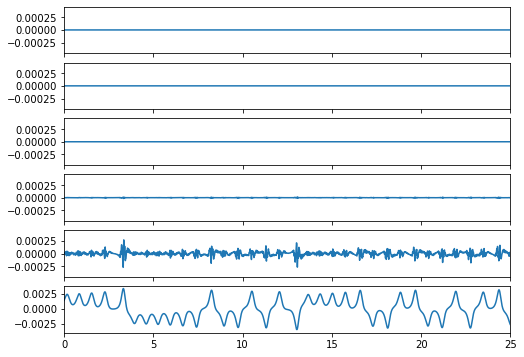

In [128]:
fig, axes = plt.subplots(len(ϵ)+1, 1, figsize=(8, len(ϵ)+1), sharex=True, sharey=False)
t̂ = Δt * np.arange(ϵ.shape[1])
for i, ax in enumerate(axes):
    if i < len(ϵ):
        ax.plot(t̂, ϵ[i])
        ax.set(xlim=(0, 25), ylim=(-1.2*abs(ϵ[-1]).max(), 1.2*abs(ϵ[-1]).max()))
    if i == len(ϵ):
        ax.plot(t̂, x[0, :-1])

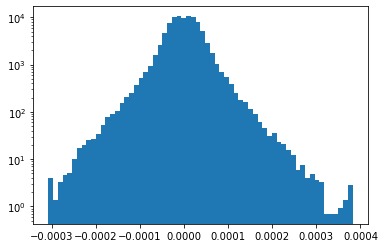

In [129]:
plt.hist(ϵ[-1], bins=64, density=True, log=True);

(-0.004003363799641757,
 0.0037727804067279407,
 -0.005195422171393677,
 0.005454065066922444)

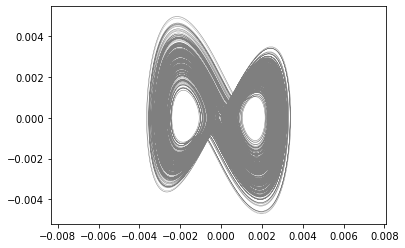

In [130]:
plt.plot(x[0], x[1], lw=0.25, alpha=0.5, c="k")
plt.axis("equal")

In [131]:
x̂ = np.zeros(x.shape)
x̂[:, 0] = x[:, 0]
for i in range(x̂.shape[1]-1):
    x̂[:, i+1] = A @ x̂[:, i]
    x̂[-1, i+1] += ϵ[-1, i]

(150.0, 200.0)

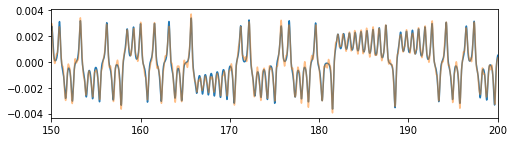

In [132]:
plt.figure(figsize=(8, 2))
plt.plot(t̂, x[abs(C).argmax(), :-1])
plt.plot(t̂, x̂[abs(C).argmax(), :-1], alpha=0.5)
plt.xlim(150, 200)

(150.0, 200.0)

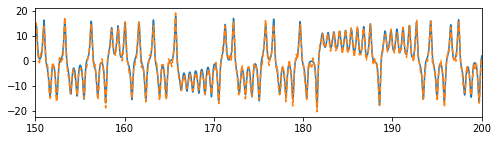

In [133]:
plt.figure(figsize=(8, 2))
plt.plot(t, obs)
plt.plot(t̂, (C @ x̂).flatten()[:-1], "--")
plt.xlim(150, 200)

([], [])

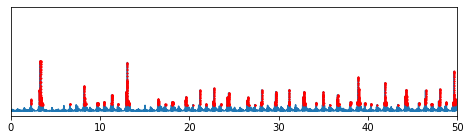

In [139]:
plt.figure(figsize=(8, 2))
plt.plot(t̂, ϵ[-1]**2)

threholds = 9e-9
plt.plot(t̂[ϵ[-1]**2 > threholds], ϵ[-1][ϵ[-1]**2 > threholds]**2, "ro", ms=1)

plt.xlim(0, 50)
plt.yticks([])

([], [])

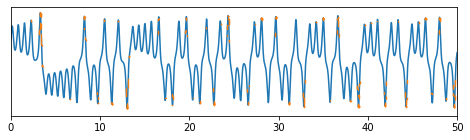

In [140]:
plt.figure(figsize=(8, 2))
plt.plot(t̂, x[abs(C).argmax(), :-1])
plt.plot(t̂[ϵ[-1]**2 > threholds], x[abs(C).argmax()][:-1][ϵ[-1]**2 > threholds], ".", markersize=0.5)
plt.xlim(0, 50)
plt.yticks([])

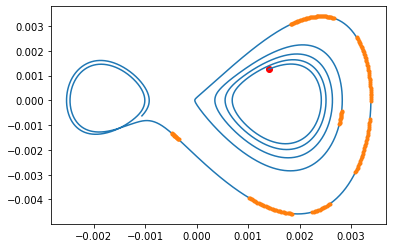

In [141]:
k = 5000
plt.plot(x[0, 0], x[1, 0], "ro")
plt.plot(x[0, :k], x[1, :k])
plt.plot(x[0, :k][ϵ[-1, :k]**2 > threholds], x[1, :k][ϵ[-1, :k]**2 > threholds], ".")

In [34]:
def rossler(t, u, p):
    # --> Unpack parameters.
    a, b, c = p
    
    # --> Unpack states.
    x, y, z = u
    
    # --> Rossler system.
    dx = -(y + z)
    dy = x + a*y
    dz = b + z*(x - c)
    
    return dx, dy, dz

In [35]:
# --> Parameters of the simulation.
tspan = (0.0, 500.0)
t = np.linspace(*tspan, 500001)
p = a, b, c = [0.1, 0.1, 14]

# --> Initial condition.
u0 = np.random.randn(3)

# --> Simulation.
output = solve_ivp(
    lambda t, u : rossler(t, u, p),
    tspan,
    u0,
    t_eval=t,
)

# --> Re-run simulation to have only data on the attractor.
u0 = output["y"][:, -1]
output = solve_ivp(
    lambda t, u : rossler(t, u, p),
    tspan,
    u0,
    t_eval=t,
)

# --> Extract observables.
y = output["y"]
Δt = t[1] - t[0]

In [36]:
Δt

0.001

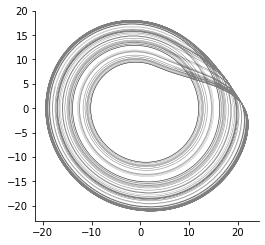

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(y[0], y[1], alpha=0.5, lw=0.25, c="k")
ax.set_aspect("equal")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

#ax.set(xticks=[], xlabel=r"$x(t)$", xlim=(-25, 25))
#ax.set(yticks=[], ylabel=r"$x(t)$", ylim=(0, 50))

In [38]:
obs = y[0]
A, C, Σ, Obs, X, Y = cca_era(obs - np.mean(obs), 100, rank=2)

(100, 499900) (100, 499900)


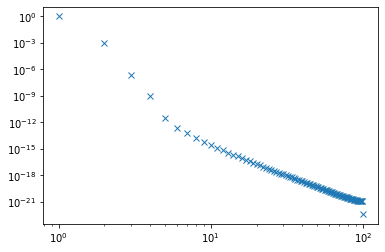

In [39]:
plt.loglog(np.arange(1, len(Σ)+1), Σ/np.sum(Σ), 'x')

[-6.27073812e-05  9.99520314e-01]
[ 0.99061325 -0.00984722]


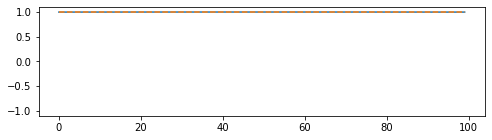

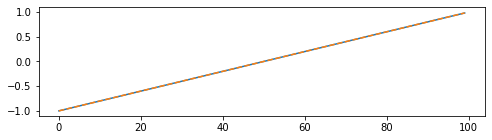

In [40]:
for i in range(Obs.shape[1]):
    fig = plt.figure(figsize=(8, 2))
    plt.plot(Obs[:, i] / abs(Obs[:, i]).max())
    plt.ylim(-1.1, 1.1)
    
    z = np.arange(0, Obs.shape[0])
    ξ = (z - z.max()/2) / (z.max()/2)
    if i == 0:
        p = np.polyfit(ξ, Obs[:, i]/abs(Obs[:, i]).max(), 1)
        plt.plot(z, np.polyval(p, ξ), '--')
        print(p)
    if i == 1:
        p = np.polyfit(ξ, Obs[:, i]/abs(Obs[:, i]).max(), 1)
        plt.plot(z, np.polyval(p, ξ), '--')        
        print(p)
    if i == 2:
        p = np.polyfit(ξ, Obs[:, i]/abs(Obs[:, i]).max(), 2)
        plt.plot(z, np.polyval(p, ξ), '--')
        print(p)
    if i == 3:
        p = np.polyfit(ξ, Obs[:, i]/abs(Obs[:, i]).max(), 3)
        plt.plot(z, np.polyval(p, ξ), '--')
        print(p)        
    if i == 4:
        p = np.polyfit(ξ, Obs[:, i]/abs(Obs[:, i]).max(), 4)
        plt.plot(z, np.polyval(p, ξ), '--')
        print(p)        

In [41]:
x = pinv(Obs) @ Y

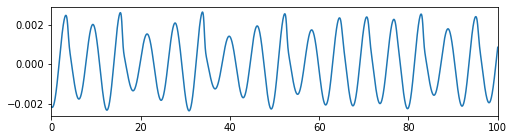

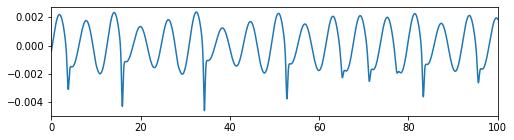

In [42]:
for i in range(len(x)):
    fig = plt.figure(figsize=(8, 2))
    plt.plot(Δt*range(x.shape[1]), x[i])
    plt.xlim(0, 100)

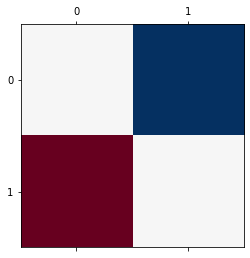

In [43]:
amp = np.abs(A-np.diag(np.diag(A))).max()
plt.matshow(A-np.diag(np.diag(A)), cmap="RdBu", vmin=-amp, vmax=amp)

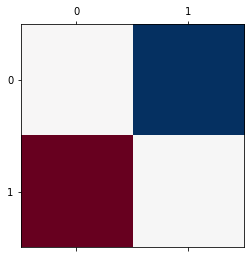

In [44]:
amp = abs(logm(A)).max()
plt.matshow(logm(A), cmap="RdBu", vmin=-amp, vmax=amp)

In [45]:
abs(eigvals(A))

array([1.00000111, 1.00000111])

In [46]:
eigvals(logm(A)/Δt)

array([0.00111121+1.07217489j, 0.00111121-1.07217489j])

In [47]:
B = logm(A)/Δt
B = (B - B.T)/2

In [48]:
eigvals(B)

array([0.+1.07218045j, 0.-1.07218045j])

In [49]:
Â = expm(B * Δt)

In [50]:
ϵ = x[:, 1:] - Â @ x[:, :-1]

In [51]:
Q = ϵ @ ϵ.T

In [52]:
U, Σ, Vt = svd(Q)
print(Σ)

[1.45542826e-06 9.05945685e-12]


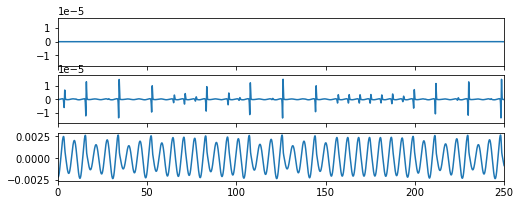

In [53]:
fig, axes = plt.subplots(len(ϵ)+1, 1, figsize=(8, len(ϵ)+1), sharex=True, sharey=False)
t̂ = Δt * np.arange(ϵ.shape[1])
for i, ax in enumerate(axes):
    if i < len(ϵ):
        ax.plot(t̂, ϵ[i])
        ax.set(xlim=(0, 250), ylim=(-1.2*abs(ϵ[-1]).max(), 1.2*abs(ϵ[-1]).max()))
    if i == len(ϵ):
        ax.plot(t̂, x[0, :-1])

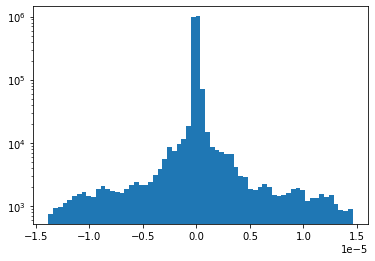

In [54]:
plt.hist(ϵ[-1], bins=64, density=True, log=True);

(-0.0026112496017523146,
 0.002904485453913091,
 -0.004983889177953864,
 0.002728295792074108)

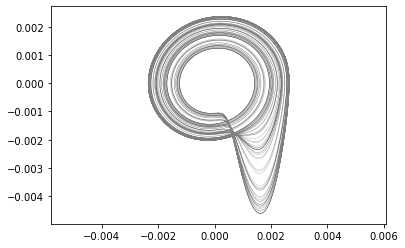

In [55]:
plt.plot(x[0], x[1], lw=0.25, alpha=0.5, c="k")
plt.axis("equal")

In [56]:
x̂ = np.zeros(x.shape)
x̂[:, 0] = x[:, 0]
for i in range(x̂.shape[1]-1):
    x̂[:, i+1] = A @ x̂[:, i]
    x̂[-1, i+1] += ϵ[-1, i]

(0.0, 250.0)

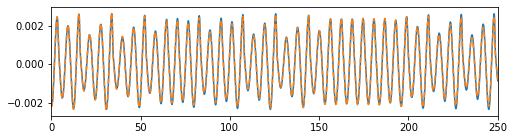

In [57]:
plt.figure(figsize=(8, 2))
plt.plot(t̂, x[abs(C).argmax(), :-1])
plt.plot(t̂, x̂[abs(C).argmax(), :-1], "--")
plt.xlim(0, 250)

(0.0, 250.0)

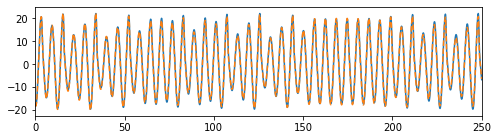

In [58]:
plt.figure(figsize=(8, 2))
plt.plot(t, obs)
plt.plot(t̂, (C @ x̂).flatten()[:-1], "--")
plt.xlim(0, 250)

([], [])

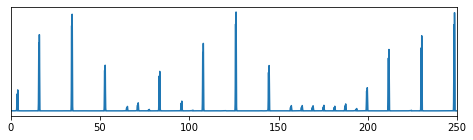

In [59]:
plt.figure(figsize=(8, 2))
plt.plot(t̂, ϵ[-1]**2)

threholds = 3e-9
plt.plot(t̂[ϵ[-1]**2 > threholds], ϵ[-1][ϵ[-1]**2 > threholds]**2, "ro", ms=1)

plt.xlim(0, 250)
plt.yticks([])

([], [])

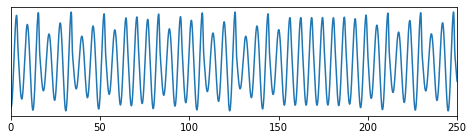

In [60]:
plt.figure(figsize=(8, 2))
plt.plot(t̂, x[abs(C).argmax(), :-1])
plt.plot(t̂[ϵ[-1]**2 > threholds], x[abs(C).argmax()][:-1][ϵ[-1]**2 > threholds], ".", markersize=0.5)
plt.xlim(0, 250)
plt.yticks([])

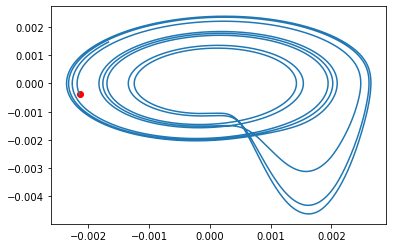

In [61]:
k = 50000
plt.plot(x[0, 0], x[1, 0], "ro")
plt.plot(x[0, :k], x[1, :k])
plt.plot(x[0, :k][ϵ[-1, :k]**2 > threholds], x[1, :k][ϵ[-1, :k]**2 > threholds], ".")